----------------------------------
   # Case Study:     Image Classification using **CNNs**
----------------------------------

## Context: 

- The ability to effectively differentiate a weed from a crop seedling can mean better crop yields and better stewardship of     the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released 
  a dataset containing images of unique plants belonging to 12 species at several growth stages.
- In this case study, we will build a multicalss classification Convolutional Nueral Network model that will classify the images provided   in the dataset mentioned above. Each image will be classifed into one the 12 possible classes\species.


## Probelm:

- Explore and visualize the dataset.
- Prprocess the dataset images before feeding them to the CNN model..
- Come up with an optimized  Convolutional Nueral Network  classification model to predict the class\specie of an image.

## Data Dictionary
- The dataset is composed of two data files.
- The data file are:
    - images.npy: Images of plant seedlings at various stages of grown, the images are stored in a Numpy Array (Height, Width,         Channel format)
    - Label.csv:  Contains the class\specie of each image from 12 possible plant species.
    - The images and their labels have the same index in both files.

## Importing necessary libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# To supress numerical display in scientific notations
pd.set_option("display.float_format", lambda x: "%5f" % x)
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
#Importing OpenCv library
import cv2

from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Conv2D, Activation, Input
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras import losses, optimizers

# To get reproducable results
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(2)

 ## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
images = np.load("/content/drive/MyDrive/images.npy")
labels= pd.read_csv('/content/drive/MyDrive/Labels.csv')
# images = np.load('images.npy')
print('Images:',images.shape)
# labels= pd.read_csv('Labels.csv')
print('Lables:',labels.shape)
print(labels.Label.value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images: (4750, 128, 128, 3)
Lables: (4750, 1)
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64


**Obervations**
- Images: The images(represent the features of the dataset) are stored in a Numpy Array (Height, Width, Channel format):
    - 4750 images.
    - The size of each image is 128x128 pixels.
    - 3 represents the number of channels, here we have 3 channels(RGB: red, green, and blue) therefore the the images are           color images.
- Labels have 4750 labels, one class\specie for each image of Images, labels represent the target varibale
- We have 12 possible classes\species:Loose Silky-bent,Common Chickweed,Scentless Mayweed,Small-flowered Cranesbill,Fat Hen   Charlock,Sugar beet,Cleavers,Black-grass,Shepherds Purse,Common wheat, and Maize. 

### Checking for missing values

In [3]:
# Check for any missing data in images.
print ('Missing values in images:', np.isnan(np.sum(images)))
# Check for any missing data in labels.
print('Missing values in labels:',labels.isnull().sum())

Missing values in images: False
Missing values in labels: Label    0
dtype: int64


**Observations**
- There is no missing values in the provided dataset.

## Exploratory Data Analysis and Image Preprocessing

### Classes\species Distribution

In [4]:
# Function to add the percentage of each class of the category
def perc_on_bar(plot, feature):
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage

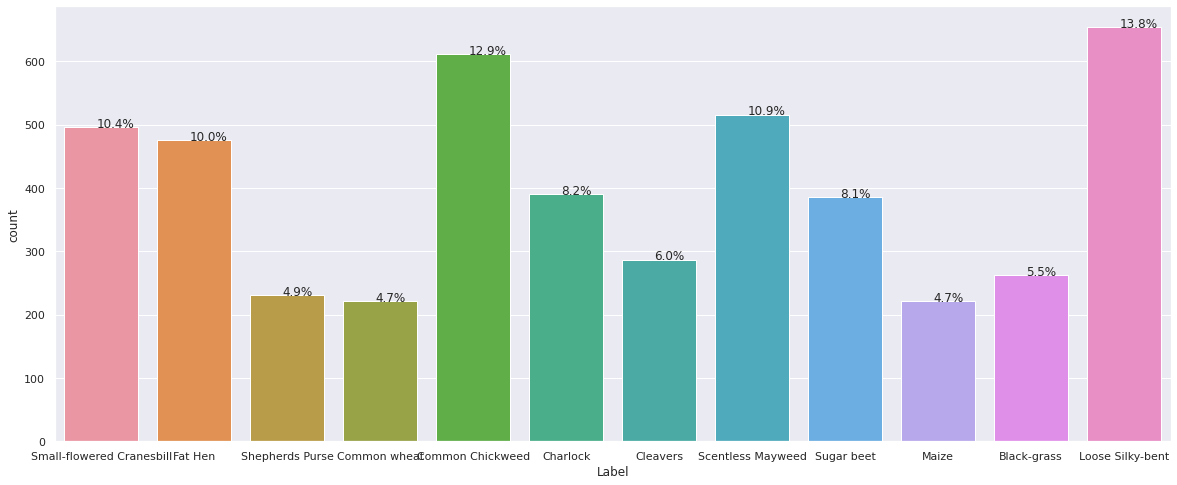

In [5]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(data=labels, x="Label")
perc_on_bar(ax, labels)

**Observations**
- 13.8% of the images are for Loose Silky-bent with 654 images.
- 12.9% of the images are for Common Chickweed with 611 images.
- 10.9% of the images are for Scentless Mayweed with 516 images.
- 10.4% of the images are for Small-flowered Cranesbill with 496 images.
- 10% of the images are for Fat Hen with 475 images.
- 8.2% of the images are for Charlock with 390 images.
- 8.1% of the images are for Sugar beet with 385 images.
- 6% of the images are for Cleavers with 287 images.
- 5.5% of the images are for Black-grass with 263 images.
- 4.9% of the images are for Shepherds Purse with 231 images.
- 4.7% of the images are for Common wheat with 221 images.
- 4.7% of the images are for Maize with 221 images.
- As we can observe this unbalanced dataset, where the percentage of each class\specie is not equal or close. For examaple the number of images of Loose Silky-bent is about 3 times the number of images of the Maize class\specie.

###  Images Visualization

- We will show three images of each class.

In [6]:
# Storing the classes\species in a list 
CATEGORIES = ["Loose Silky-bent","Common Chickweed","Scentless Mayweed","Small-flowered Cranesbill","Fat Hen","Charlock",\
              "Sugar beet","Cleavers","Black-grass","Shepherds Purse","Common wheat","Maize"]
#List to store the indexes of images to show.
sampleindexes =[]
for cat in CATEGORIES:
    # Sampling three indexes from each class\specie and store them in sampleindexes list
    sampleindexes.append(labels[labels.Label==cat].sample(3).index)
# flat_list will have sampleindexes flattened(from a list of lists of indexes to a list of indexes)
flat_list = [item for sublist in sampleindexes for item in sublist]

- Showing 36 images in a 6 columns by 6 rows grid, three images of each calss\specie.

In [7]:
#The number of image in the grid
sampleimage=1
fig = plt.figure(figsize = (20,20))
for index in flat_list:
    # 6x6 grid to show a total of 36 images, sampleimage is the number of the image in the grid.
    ax = fig.add_subplot(6, 6, sampleimage)
    # Showing the image from images
    plt.imshow(images[index])
    # Adding the title of the image as the specie of the the showed image, here we will show 3 images, so each specie will
    # have three sampleimage, e.g sampleimage with values 1,2,3 will show the Loose Silky-bent which has index 0 in CATEGORIES
    plt.title(CATEGORIES[int((sampleimage-1)/3) ])
    # incrementing sampleimage to show the next image(reserving the next spot in the 6x6 grid)
    sampleimage+=1
    plt.axis('off')
plt.show()

**Observations**
- Three images are showed from each class\specie of the 12 classes, totaling 36 images. 
- We can observe that in the image each plant for a given specie differs in orientation, position, and size with respect to the image size, also we can notice that the back ground differs as well.  

### Mean image of each class

In [10]:
# Grouping the indexes by class\specie
index_by_classes =[]
for cat in CATEGORIES:
    index_by_classes.append(labels[labels.Label==cat].index)

In [11]:
fig = plt.figure(figsize = (20,20))

for index in range(0,12):
    # A grid with  3 rows and 4 columns to show a mean image of each of the 12 classes\species
    ax = fig.add_subplot(3, 4, index+1)
    # Computing the mean of each class, we will need to to flatten the 2x2 image matrix to a vector, then take the mean of each
    # Column(axis=0)
    mean_image=(np.mean(images[index_by_classes[index], :].reshape(index_by_classes[index].shape[0],16384,3) ,axis=0))
    # Showing the mean image of the specie after rshaping  back to a matrix
    plt.imshow((mean_image.reshape( 128, 128,3))/255.0)
    # Adding the specie\class to the image.
    plt.title(CATEGORIES[index])
    plt.axis('off')
plt.show()

**Observations**
- Some of the images seems to be darker in some spots, while the rest seems to have the same intensity(or very close) distribution for all the pixels, let's see if we can better observe these patterns when we transform the images from color to gray.

#### Transforming the color images to graysclae images

In [8]:
# The third axis in images represent the channels, to transform the color image to grey image we need to take the median of the
# intensities of the three channels(RGB: red, green, and blue)
images_grayscale = images.mean(axis=3).astype(np.float32) 
# Reshaping images_graysclae to add channel axis which will be here equal to 1 since grey images have only 1 channel.
# images_grayscale = images_grayscale.reshape(4750, 128, 128, 1) 

- Showing 36 gray images in a 6 columns by 6 rows grid, three images of each calss\specie.

In [9]:
#The number of image in the grid
sampleimage=1
fig = plt.figure(figsize = (20,20))
for index in flat_list:
    # 6x6 grid to show a total of 36 grey images, sampleimage is the number of the image in the grid.
    ax = fig.add_subplot(6, 6, sampleimage)
      # Showing the image from images_grayscale
    plt.imshow(images_grayscale[index],cmap='gray')
    # Adding the title of the image as the specie of the the showed image, here we will show 3 images, so each specie will
    # have three sampleimage indexes, e.g sampleimage with values 1,2,3 will show the Loose Silky-bent which is index 0 
    # in CATEGORIES
    plt.title(CATEGORIES[int((sampleimage-1)/3) ])
    sampleimage+=1
    plt.axis('off')
plt.show()

**Observations**
- The transformation was successful, as we can see three grey images were showed for each specie totaling 36 grey images.

### Computing and showing  the mean gray image of each Class\Specie

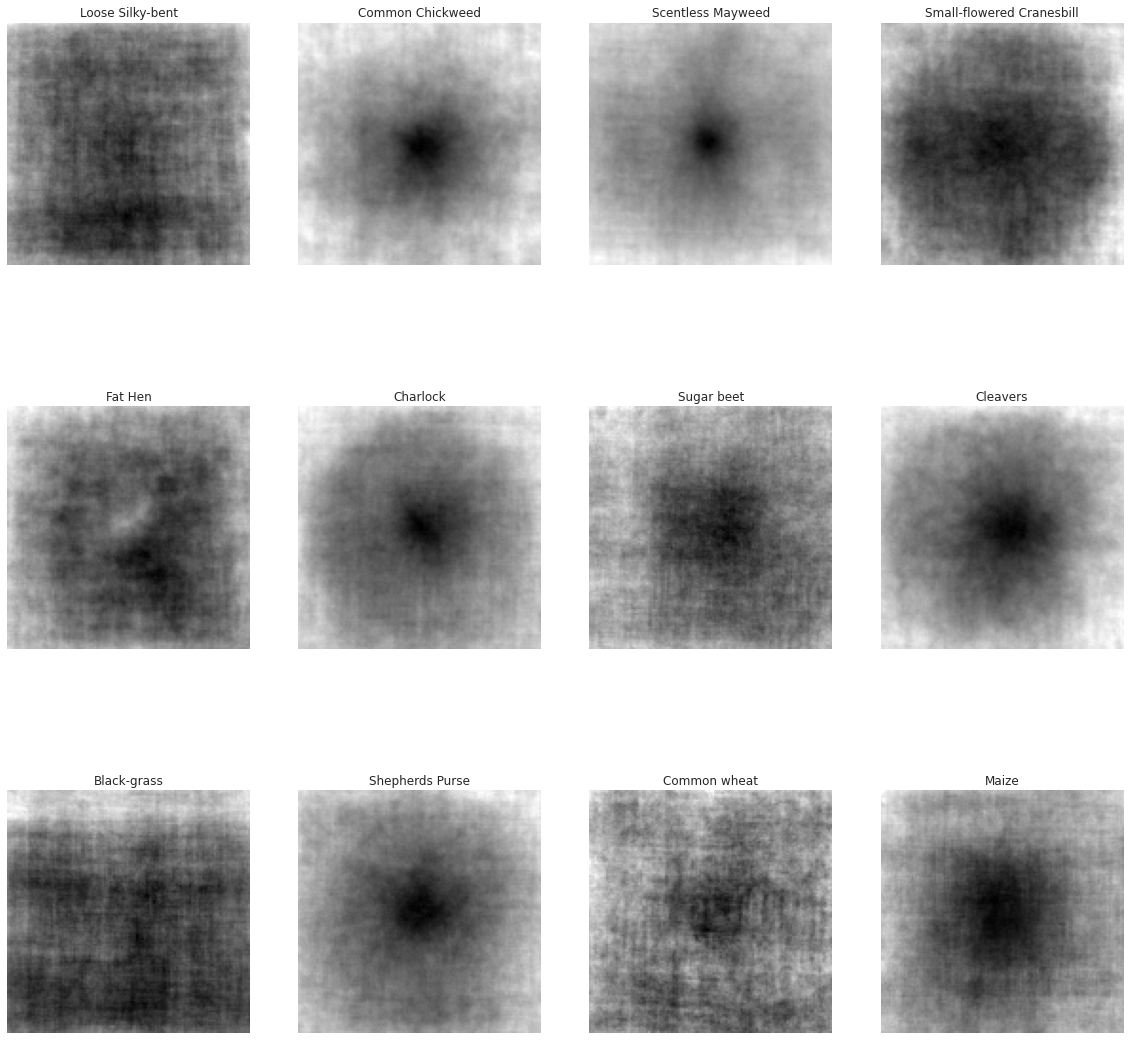

In [12]:
fig = plt.figure(figsize = (20,20))
# list to store the mean image of each class.
mean_images=[]
for index in range(0,12):
    # A grid with  3 rows and 4 columns to show a mean image of each of the 12 classes\species
    ax = fig.add_subplot(3, 4, index+1)
    # Computing the mean of each class, we will need to to flatten the 2x2 image matrix to a vector, then take the mean of each
    # Column(axis=0)
    mean_image=(np.mean(images_grayscale[index_by_classes[index], :].reshape(index_by_classes[index].shape[0],16384,1) ,axis=0))
    # Adding the mean image to the list
    mean_images.append(mean_image)
    # Showing the mean image of the specie after rshaping  back to a matrix
    plt.imshow(mean_image.reshape( 128, 128),cmap="gray")
    # Adding the specie\class to the image.
    plt.title(CATEGORIES[index])
    plt.axis('off')
plt.show()

**Observations**
- We can observe that the mean image is different from the showed images(not even close), this can be explained by the different location,position,orientation of the plant and the back ground from a given specie image to an other image.
- Mean images for: Common Chickweed,Scentless Mayweed, Charlock, Cleavers,Shepherds Purse, and Maize have a close distrubution where the center and its surrounding area of the mean image have a very dark grey color (pixels of value zero or close to zero), then the color goes lighter as we go further from the center.
- For the rest the very dark pixels are not concentrated in the center.
- Let's check the histograms of pixel intensities of each mean image.

### Histograms of pixel intensities of each class mean image

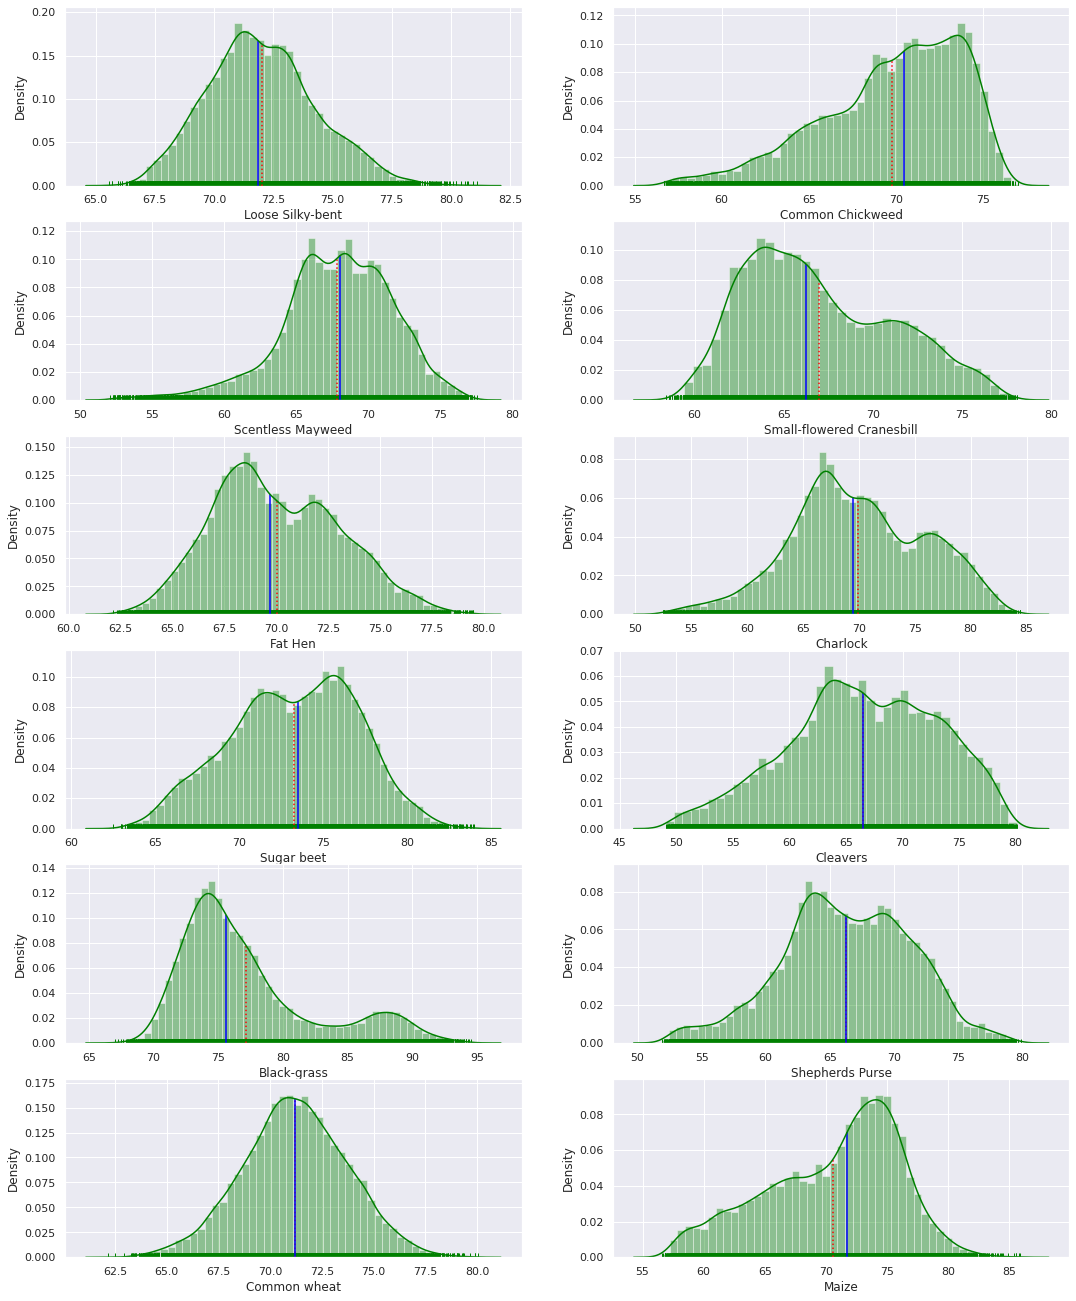

In [13]:
# plotting histograms for pixel intensities of each mean image.


# Row i and Column j represented by axes[i,j] will represnt one histogram
# For example the 4th mean image of Small-flowered Cranesbill specie will have an index equal to 3
# int(3/2)=1 and 3%2=1(the rest) that will be in second row  and second column
fig, axes = plt.subplots(6, 2, figsize=(18, 23))
for i in range(len(mean_images)):
    ax = sns.distplot(
        ax=axes[int(i / 2), i % 2],
        x=mean_images[i],
        color="green",
        rug=True,
        axlabel=CATEGORIES[i],
    )
    line = ax.lines[0]
    xs = line.get_xdata()
    ys = line.get_ydata()
    # Plotting a dotted  red line for the mean after calculting the mean and the height of the line
    mean = np.mean(mean_images[i])
    height_mean = np.interp(mean, xs, ys)
    ax.vlines(mean, 0, height_mean, color="red", ls="dotted")
    # Plotting a solid blue line for the median after calculting the median and the height of the line
    median = np.median(mean_images[i])
    height_median = np.interp(median, xs, ys)
    ax.vlines(median, 0, height_median, color="blue", ls="solid")

**Observations**
- The distribution of the mean image of Common Chickweed and Maize are left skewed. 
- The distribution of the mean image of Black-grass, Fat Hen, and Small-flowered Cranesbill are right skewed.
- The rest are almost normally distributed. 
- Few images have pixles with intensity bigger than 80, however 95 is the heigest pixel intensity which is present only in the Black_grass class. This can explain the dominance of the very dark color.

### Normalizing pixel values

In [14]:
# The range of the intesity a pixel is between 0 and 255, dividing by 255 will result to a vale in the range [0,1]
images=images/255.0
#Checking the shape after normalization
print(images.shape)
#Checking the values after normalization
print(images)

(4750, 128, 128, 3)
[[[[0.1372549  0.20392157 0.30588235]
   [0.14117647 0.19215686 0.29803922]
   [0.12156863 0.17647059 0.27058824]
   ...
   [0.30588235 0.37254902 0.44705882]
   [0.29803922 0.36470588 0.43137255]
   [0.31372549 0.37254902 0.42745098]]

  [[0.12941176 0.18039216 0.26666667]
   [0.14509804 0.19607843 0.28627451]
   [0.18823529 0.25490196 0.3254902 ]
   ...
   [0.31764706 0.37647059 0.44313725]
   [0.29019608 0.34901961 0.41176471]
   [0.3254902  0.37254902 0.42745098]]

  [[0.13333333 0.19607843 0.26666667]
   [0.1372549  0.20392157 0.28235294]
   [0.2745098  0.33333333 0.39607843]
   ...
   [0.3254902  0.38039216 0.43921569]
   [0.30980392 0.36862745 0.42352941]
   [0.30980392 0.36862745 0.41960784]]

  ...

  [[0.1372549  0.19607843 0.27058824]
   [0.16470588 0.22352941 0.28627451]
   [0.16470588 0.22352941 0.28235294]
   ...
   [0.23529412 0.29803922 0.36078431]
   [0.2627451  0.31764706 0.38039216]
   [0.25098039 0.30196078 0.37254902]]

  [[0.14117647 0.20392157

**Observations**
- The normalization was successfull. All intensity values are between 0 and 1.

### Image Smoothing to reduce the noise
- Gaussian blur also known as Gaussian smoothing is used to reduce image noise and to reduce details.
- It is used as a pre-processing stage in computer vision algorithms in order to enhance image structures. This operation will yield to a better model performance.
- OpenCV provides cv2.gaussianblur() function to apply Gaussian Smoothing on an image.

In [15]:
# Creating empty np array to store the blurred images
images_blurred = np.empty((4750, 128, 128,3)) 

# Now we apply the gaussian blur to each 128x128 pixels array (image) to reduce the noise in the image, the kernel size is 5x5
for idx, img in enumerate(images):
  images_blurred[idx] = cv2.GaussianBlur(img, (5,5), 0)

### Showing a sample image from each class before and  after Gaussian smoothing 

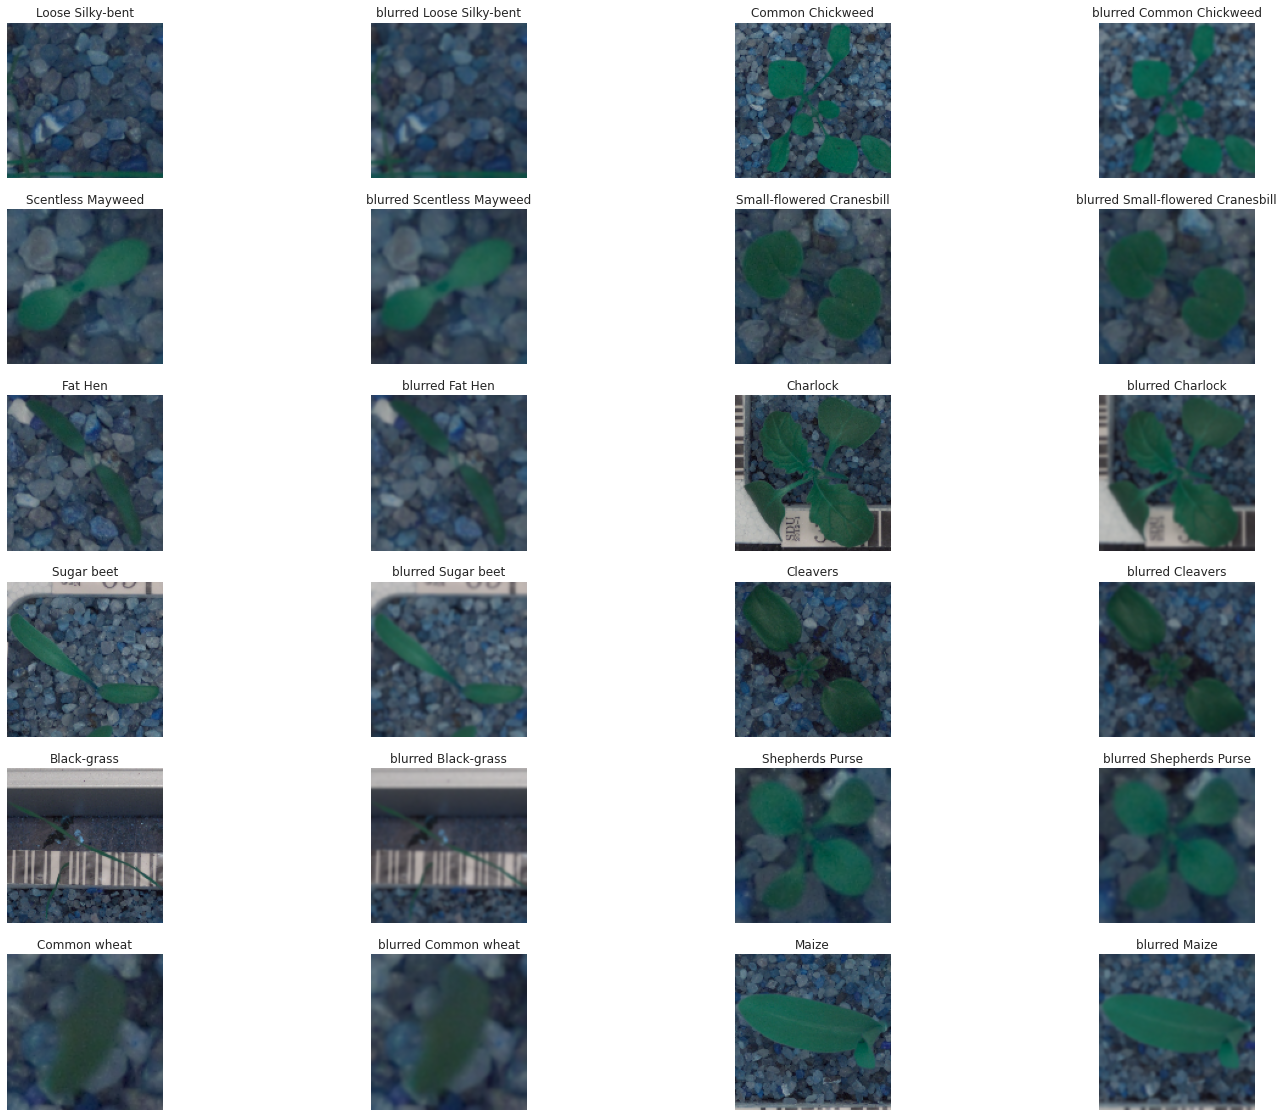

In [16]:
sampleimage=1
#flag to control when to show original or blurred image
blurr= False ;
fig = plt.figure(figsize = (25,20))
# index of the class 
index=0
while(index<12):
    ax = fig.add_subplot(6, 4, sampleimage)
    if(not blurr):
        #from the ith class show the original 10th image
        plt.imshow(images[index_by_classes[index][9]])
        #show the class as title
        plt.title( CATEGORIES[index ])
        plt.axis('off')
        #original image showed, next will the blurred image
        blurr= True
    else:
        #from the ith class show the blurred 10th image
        plt.imshow(images_blurred[index_by_classes[index][9]])
        #show the class as title
        plt.title('blurred '+ CATEGORIES[index])
        plt.axis('off')
        #next we will show an unblurred image
        blurr=False
        # both original and blurred image of the current class were showed, incrementi to go to the next class
        index+=1
    #incremnet to the show the next image in the grid    
    sampleimage+=1

plt.show()

**Observations**
- As we can see the smoothing was successful, we can clearly see the difference between the original image and the smoothed one which is blurred.

### Data splitting and One-Hot Encoding

In [18]:
#Integer encoding for the lables, this is needed for one hot encoding
labelmap={"Loose Silky-bent":0,"Common Chickweed":1,"Scentless Mayweed":2,"Small-flowered Cranesbill":3,"Fat Hen":4,"Charlock":5\
              ,"Sugar beet":6,"Cleavers":7,"Black-grass":8,"Shepherds Purse":9,"Common wheat":10,"Maize":11}
labels['Label']=labels['Label'].map(labelmap)
# Split images_blurred and labels into train and test sets in 80:20 ratio, stratify=y:to ensure that relative class 
# frequencies are approximately preserved in train and test sets(since this unbalanced dataet).
X_train, X_test, y_train, y_test = train_test_split(
    images_blurred, labels, test_size=0.20, random_state=1, stratify=labels
)

## One-Hot encoding of the labels:y
y_test_encoded = to_categorical(np.array(y_test))
y_train_encoded= to_categorical(np.array(y_train))

In [19]:
#Transforming the shape of the input by adding the channel dimension in order to have the correct format for Keras
X_train=X_train.reshape(X_train.shape[0], 128, 128,3)
X_test=X_test.reshape(X_test.shape[0], 128, 128,3)
print('X Train:',X_train.shape)
print('X Test:',X_test.shape)

X Train: (3800, 128, 128, 3)
X Test: (950, 128, 128, 3)


**Observations**
- Our train sets are ready for modeling.

In [20]:
#checking that y is one-hot encoded
y_train_encoded[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

**Observations**
- One-hot encoding was successful, the above represents Small-flowered Cranesbill class.

### Model evaluation criterion

- Unfortunately, we cannot decide the best model based on test accuracy here because we are dealing with an imbalanced dataset, so we are more concerned with Precision and Recall. Since these two metrics are both quite important in this scenario, we will also check the F1(The harmonic mean of precision and recall) score to try to achieve a good balance between Precision and Recall.
- So our goal is to maximize the F1 score as much as possible and acheiving a good\acceptable accuracy as well.

### Function to create the confusion matrix, and to calculate accuracy, recall, precision, and f1-score

In [21]:
def confusion_matrix_and_metrics(
    cf,
    group_names=["True Negative", "False Positive", "False Negative", "True Positive"],
    categories=["Loose Silky-bent","Common Chickweed","Scentless Mayweed","Small-flowered Cranesbill","Fat Hen","Charlock",\
              "Sugar beet","Cleavers","Black-grass","Shepherds Purse","Common wheat","Maize"],
    count=True,
    percent=True,
    cbar=True,
    xyticks=True,
    xyplotlabels=True,
    sum_stats=True,
    figsize=(10,10),
    cmap="Reds",
    title="Confusion Matrix and Metric Scores",
):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    """

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ["" for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{var1}{var2}{var3}".strip()
        for var1, var2, var3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        precision = cf[1, 1] / sum(cf[:, 1])
        recall = cf[1, 1] / sum(cf[1, :])
        f1_score = 2 * precision * recall / (precision + recall)
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy, precision, recall, f1_score)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get("figure.figsize")

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        cf,
        annot=box_labels,
        fmt="",
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
    )

    if xyplotlabels:
        plt.ylabel("True label")
        plt.xlabel("Predicted label" + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

## Implementing Convolutional Neural Network Models

### model1
- We will use 3 conv layers with padding and a Relu activation, the first layer will have 64 kernels with a kernel size of 5x5. The second and third layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a sttrdie of 2 for each ax, this will be done after each conv layer.
-  We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 300 nodes, second hidden layer will have 150 nodes. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout and early stopping to control overfitting.

In [22]:
# Initialize the model
model1 = Sequential()
# Adding first conv layer
model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
## Adding maxpooling layer and dropout
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Dropout(0.3))
# Adding second conv layer
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
## Adding maxpooling layer and dropout
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))
# Adding third conv layer
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
## Adding maxpooling layer and dropout
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))
# Flatting the output of the last layer to a vector(from a 2x2 matrix) to be the input of the first dense layer
model1.add(Flatten())
#Adding first dense layer and dropout
model1.add(Dense(300, activation = "relu"))
model1.add(Dropout(0.3))
#Adding second dense layer and dropout
model1.add(Dense(150, activation = "relu"))
model1.add(Dropout(0.3))
#Adding output layer with a softmax activation(since this a multi-class classification)
model1.add(Dense(12, activation = "softmax"))
# Setting opyimizer for Adam and a learning rate of 0.001
optimizer = optimizer=optimizers.Adam(learning_rate=0.001)
#Comppiling the model
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Initialize early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#fitting the model(model Training: Forward pass and Backpropagation to adjust the kernels values)
history1=model1.fit(X_train, 
          y_train_encoded, 
          epochs=40, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2, callbacks=[es],use_multiprocessing=True)  

Epoch 1/40
48/48 [==============================] - 11s 66ms/step - loss: 2.4968 - accuracy: 0.1217 - val_loss: 2.4507 - val_accuracy: 0.1763
Epoch 2/40
48/48 [==============================] - 2s 44ms/step - loss: 2.4233 - accuracy: 0.1566 - val_loss: 2.3378 - val_accuracy: 0.2474
Epoch 3/40
48/48 [==============================] - 2s 43ms/step - loss: 2.0988 - accuracy: 0.2826 - val_loss: 1.7454 - val_accuracy: 0.3934
Epoch 4/40
48/48 [==============================] - 2s 43ms/step - loss: 1.7268 - accuracy: 0.3898 - val_loss: 1.5976 - val_accuracy: 0.4434
Epoch 5/40
48/48 [==============================] - 2s 43ms/step - loss: 1.5512 - accuracy: 0.4622 - val_loss: 1.3593 - val_accuracy: 0.5579
Epoch 6/40
48/48 [==============================] - 2s 44ms/step - loss: 1.3900 - accuracy: 0.5109 - val_loss: 1.3161 - val_accuracy: 0.5789
Epoch 7/40
48/48 [==============================] - 2s 44ms/step - loss: 1.2524 - accuracy: 0.5589 - val_loss: 1.2246 - val_accuracy: 0.5987
Epoch 8/40
4

#### Plotting the train and validation accuracy

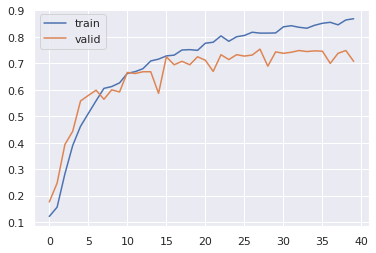

In [23]:
# Capturing learning history per epoch
hist1 = pd.DataFrame(history1.history)
hist1["epoch"] = history1.epoch

# Plotting the accuracies at different epochs
plt.plot(hist1["accuracy"])
plt.plot(hist1["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Obervations**
- The model didn't have a good generalization and did overfit. The model performed better(by ~20%) on the train set than the validation set.

### Model Evaluation

In [24]:
## Confusion Matrix on unseen test set
y_pred1=model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1,axis=1)
cm1 = confusion_matrix(np.array(y_test), y_pred1_classes)
confusion_matrix_and_metrics(cm1)

**Observations**
- model1 did achieve an accuracy of 72.9% and a f1 score of 86.4%
- model1 did overfit, let's try another model with a less complexity architecture.

### model2
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 32 kernels with a kernel size of 5x5. The second will have 64 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a stride of 2 for each ax, this will be done after each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 64 nodes, second hidden layer will have 32 nodes. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [25]:
#Initialize model2
model2 = Sequential()
# Adding the 4 conv layers where each conv layer is followed by a maxpooling layer then dropout.
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))
#Flattening the output of the last maxpooling layer to be ready for the first dense layer.
model2.add(Flatten())
#Adding two hidden layers, each one is followed by dropout
model2.add(Dense(64, activation = "relu"))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation = "relu"))
model2.add(Dropout(0.2))
##Adding the output layer.
model2.add(Dense(12, activation = "softmax"))
#Setting optimizer for Adam with a learning rate of 0.00075
optimizer = optimizer=optimizers.Adam(learning_rate=0.00075)
#Compiling the model
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#Fitting the model(training)
history2=model2.fit(X_train, 
          y_train_encoded,  
          epochs=60, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2,use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/60
48/48 [==============================] - 3s 42ms/step - loss: 2.4631 - accuracy: 0.1211 - val_loss: 2.4604 - val_accuracy: 0.1289
Epoch 2/60
48/48 [==============================] - 1s 28ms/step - loss: 2.4362 - accuracy: 0.1303 - val_loss: 2.4347 - val_accuracy: 0.1250
Epoch 3/60
48/48 [==============================] - 1s 27ms/step - loss: 2.4148 - accuracy: 0.1579 - val_loss: 2.3181 - val_accuracy: 0.2329
Epoch 4/60
48/48 [==============================] - 1s 28ms/step - loss: 2.2292 - accuracy: 0.2385 - val_loss: 2.0077 - val_accuracy: 0.3539
Epoch 5/60
48/48 [==============================] - 1s 27ms/step - loss: 1.9655 - accuracy: 0.3319 - val_loss: 1.8399 - val_accuracy: 0.4092
Epoch 6/60
48/48 [==============================] - 1s 28ms/step - loss: 1.8109 - accuracy: 0.3717 - val_loss: 1.7990 - val_accuracy: 0.4118
Epoch 7/60
48/48 [==============================] - 1s 28ms/step - loss: 1.7435 - accuracy: 0.3961 - val_loss: 1.6757 - val_accuracy: 0.4763
Epoch 8/60
48

#### Plotting the train and validation accuracy

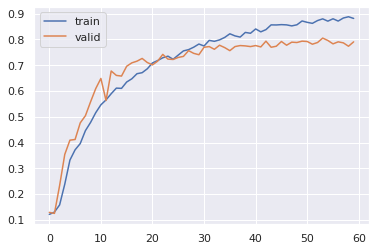

In [26]:
# Capturing learning history per epoch
hist2 = pd.DataFrame(history2.history)
hist2["epoch"] = history2.epoch

# Plotting the accuracies at different epochs
plt.plot(hist2["accuracy"])
plt.plot(hist2["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Observations**
- model2 has a less overfitting than model1, the performance for train set is ~10% more than validation set.
- We reduced the overfitting by 10%.

### Model Evaluation

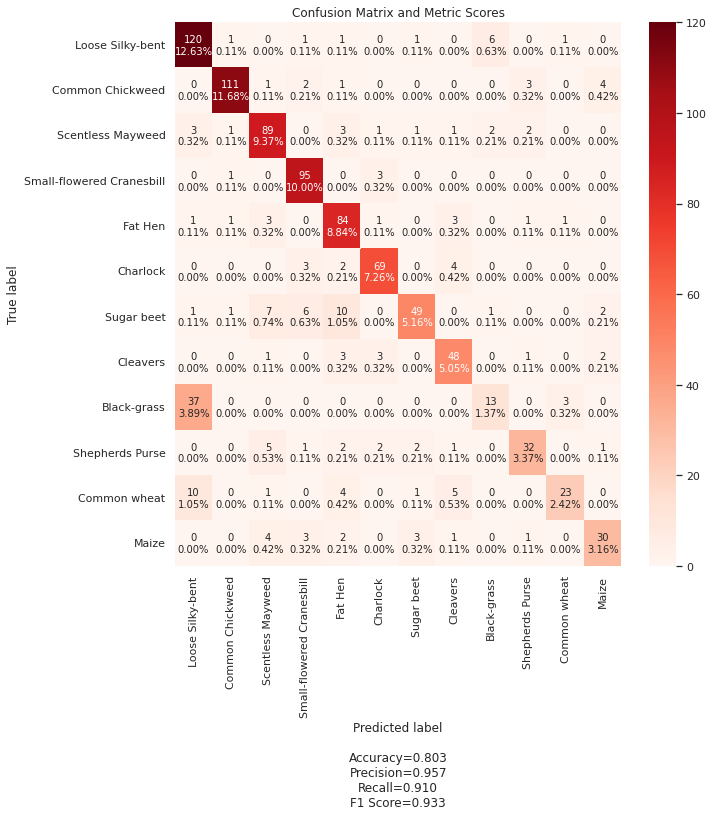

In [27]:
y_pred2=model2.predict(X_test)
y_pred2_classes = np.argmax(y_pred2,axis=1)
cm2 = confusion_matrix(np.array(y_test), y_pred2_classes)
confusion_matrix_and_metrics(cm2)

**Observations**
- model2 did achieve an accuracy of 80.3% and a f1 score of 93.3%. 
- model2 did have a better performance than model1 with better generalization as well, however model2 is still overfitting, let's try another model with a less complexity architecture(we will drop the number of nodes of first hidden layer from 64 to 32), and keep 4 conv layers.

### model3
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 40 kernels with a kernel size of 5x5. The second will have 80 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a stride of 2 for each ax, this will be done after each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 32 nodes, second hidden layer will have 32 nodes as well. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [28]:
#Initialize model3
model3 = Sequential()
# Adding the 4 conv layers where each conv layer is followed by a maxpooling layer then dropout.
model3.add(Conv2D(filters = 40, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters = 80, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model3.add(Dropout(0.2))
#Flattening the output of the last maxpooling layer to be ready for the first dense layer.
model3.add(Flatten())
#Adding two dense layers with dropout
model3.add(Dense(32, activation = "relu"))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation = "relu"))
model3.add(Dropout(0.2))
#Adding output layer
model3.add(Dense(12, activation = "softmax"))
#Choosing adam as optimizer with a learning rate of 0.0075
optimizer = optimizer=optimizers.Adam(learning_rate=0.00075)
#Compiling the model
model3.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#Fitting the model
history3=model3.fit(X_train, 
          y_train_encoded, 
          epochs=80, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2,use_multiprocessing=True)#number of samples per gradient update for training  



Epoch 1/80
48/48 [==============================] - 3s 51ms/step - loss: 2.4515 - accuracy: 0.1319 - val_loss: 2.4426 - val_accuracy: 0.1711
Epoch 2/80
48/48 [==============================] - 2s 36ms/step - loss: 2.4362 - accuracy: 0.1329 - val_loss: 2.4438 - val_accuracy: 0.1250
Epoch 3/80
48/48 [==============================] - 2s 35ms/step - loss: 2.4191 - accuracy: 0.1454 - val_loss: 2.3331 - val_accuracy: 0.2526
Epoch 4/80
48/48 [==============================] - 2s 36ms/step - loss: 2.2552 - accuracy: 0.2388 - val_loss: 2.0677 - val_accuracy: 0.2882
Epoch 5/80
48/48 [==============================] - 2s 35ms/step - loss: 2.0523 - accuracy: 0.2901 - val_loss: 1.8745 - val_accuracy: 0.3750
Epoch 6/80
48/48 [==============================] - 2s 35ms/step - loss: 1.9133 - accuracy: 0.3253 - val_loss: 1.7606 - val_accuracy: 0.4013
Epoch 7/80
48/48 [==============================] - 2s 36ms/step - loss: 1.7719 - accuracy: 0.3789 - val_loss: 1.6345 - val_accuracy: 0.4263
Epoch 8/80
48

#### Plotting the train and validation accuracy

In [29]:
# Capturing learning history per epoch
hist3 = pd.DataFrame(history3.history)
hist3["epoch"] = history3.epoch

# Plotting the accuracies at different epochs
plt.plot(hist3["accuracy"])
plt.plot(hist3["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Observations**
- model3 did have a very good generalization.

### Model Evaluation

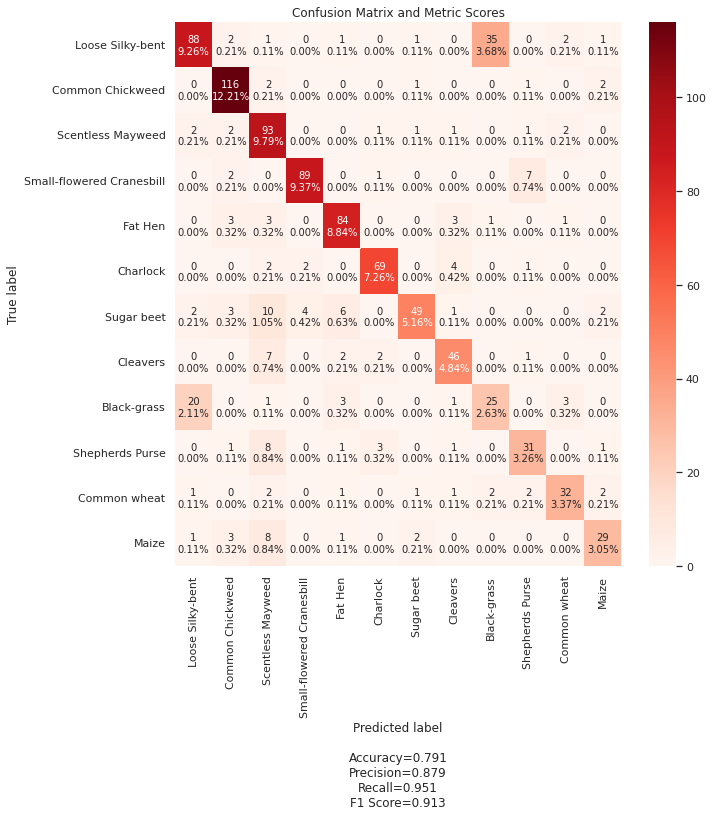

In [30]:
y_pred3=model3.predict(X_test)
y_pred3_classes = np.argmax(y_pred3,axis=1)
cm3 = confusion_matrix(np.array(y_test), y_pred3_classes)

confusion_matrix_and_metrics(cm3)

**Observations**
- model3 achieved an accurracy of 79.1% and f1 score of 91.3%
- So far model3 is our best model when compared to model1 and model2 with regarsd to scores and generalization.
- Let's see if we can improve mode3 performance, we will try a simpler dense layers.

### model4
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 40 kernels with a kernel size of 5x5. The second will have 80 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a stride of 2 for each ax, this will be done after each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 24 nodes, second hidden layer will have 24 nodes as well. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [31]:
#Initialize model4
model4 = Sequential()
#Adding four conv layers each followed by a  maxpooling layers and then dopout as explained previously
model4.add(Conv2D(filters = 40, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model4.add(MaxPool2D(pool_size=(2,2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(filters = 80, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model4.add(Dropout(0.2))
#Flattening the output to a vector.
model4.add(Flatten())
#Adding two dense layers with dropouts
model4.add(Dense(24, activation = "relu"))
model4.add(Dropout(0.2))
model4.add(Dense(24, activation = "relu"))
model4.add(Dropout(0.2))
#Adding output layer with a softmax activation.
model4.add(Dense(12, activation = "softmax"))
#Choosing Adam as optimizer with learning rate of 0.00075
optimizer = optimizer=optimizers.Adam(learning_rate=0.00075)
#Compiling model4
model4.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#fitting the model to the data (training)
history4=model4.fit(X_train, 
          y_train_encoded,  
          epochs=100, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2,use_multiprocessing=True)#number of samples per gradient update for training  

Epoch 1/100
48/48 [==============================] - 3s 43ms/step - loss: 2.4803 - accuracy: 0.1069 - val_loss: 2.4707 - val_accuracy: 0.0882
Epoch 2/100
48/48 [==============================] - 2s 35ms/step - loss: 2.4494 - accuracy: 0.1247 - val_loss: 2.3615 - val_accuracy: 0.2237
Epoch 3/100
48/48 [==============================] - 2s 36ms/step - loss: 2.2862 - accuracy: 0.2382 - val_loss: 2.1063 - val_accuracy: 0.2934
Epoch 4/100
48/48 [==============================] - 2s 35ms/step - loss: 2.1185 - accuracy: 0.2855 - val_loss: 1.9281 - val_accuracy: 0.3724
Epoch 5/100
48/48 [==============================] - 2s 36ms/step - loss: 1.9590 - accuracy: 0.3414 - val_loss: 1.7955 - val_accuracy: 0.3947
Epoch 6/100
48/48 [==============================] - 2s 35ms/step - loss: 1.8649 - accuracy: 0.3457 - val_loss: 1.7987 - val_accuracy: 0.3961
Epoch 7/100
48/48 [==============================] - 2s 35ms/step - loss: 1.8451 - accuracy: 0.3569 - val_loss: 1.7828 - val_accuracy: 0.4105
Epoch 

#### Plotting the train and validation accuracy

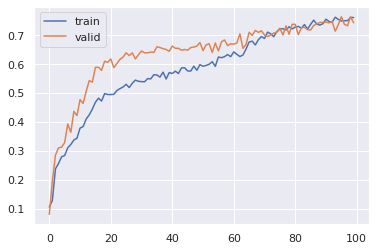

In [32]:
# Capturing learning history per epoch
hist4 = pd.DataFrame(history4.history)
hist4["epoch"] = history4.epoch

# Plotting the losses at different epochs
plt.plot(hist4["accuracy"])
plt.plot(hist4["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Observations**
- model4 did generalize well.

### Model Evaluation

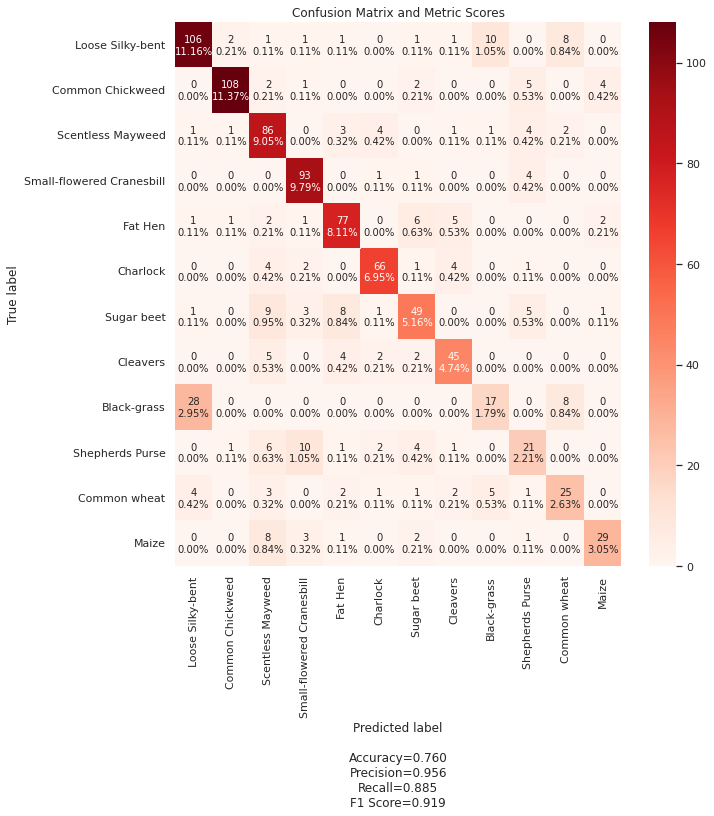

In [33]:
y_pred4=model4.predict(X_test)
y_pred4_classes = np.argmax(y_pred4,axis=1)
cm4 = confusion_matrix(np.array(y_test), y_pred4_classes)

confusion_matrix_and_metrics(cm4)

**Observations**
- model4 did achieve an accuracy of 76% and f1 score of 91.9%.
- model4 and model3 have a very good and close performance. model4 performed slightly better with regard to f1 score (by 0.8%) and generalization, and model3 performed a littele better with regards to accuracy by 3%
- Let's try data augmentation in order to improve the performance since CNN excels with larger data sets.

### Data Augmentation

- In most of the real life case studies, it is generally difficult to collect lots and lots of images and then train the CNNs which is our case today(some classes have only about 210 images, the best class have a little more than 600 images). 
- In that case we can take help of the data augmentation techniques. CNNs have the property of **translational invariance** i.e it can recognize an object as an object, even when its appearance varies in some way. Taking this property into consideration, we can augment the images using following techniques:
    1. Horizontal flip (should be set to True/False)
    2. Vertical flip (should be set to True/False)
    3. Height Shift (should be between 0 and 1)
    4. Width Shift (should be between 0 and 1)
    5. Rotation (should be between 0 and 180)
    6. Shear (should be between 0 and 1)
    7. Zoom (should be between 0 and 1) etc.
***not to use data augmentation in validation data set***.

In [23]:
#Importing ImageDataGenerator method to augment the training data.
from keras.preprocessing.image import ImageDataGenerator
#Initializing our ImageDataGenerator with parameters only for train set 
train_datagen = ImageDataGenerator( horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

validation_datagen  = ImageDataGenerator()

In [24]:
# Since no augmentation for validation set, we need to further split our train set into train and validation sets
# we will do 80% for train and 20% for validation
X_train_aug, X_val, y_train_encoded_aug, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.20, random_state=1, stratify=y_train_encoded)
# Flowing training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow(X_train_aug,y_train_encoded_aug,batch_size=64)     
# Flowing validation images in batches of 64 using test_datagen generator
validation_generator =  validation_datagen.flow(X_val, y_val,batch_size=64)
validationX, validationY = validation_generator.next()

### model5
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 40 kernels with a kernel size of 5x5. The second will have 80 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a stride of 2 for each ax, this will be done after each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 32 nodes, second hidden layer will have 32 nodes as well. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [25]:
#Initialize model5
model5 = Sequential()
#Adding four conv layers each followed by a  maxpooling layers and then dopout as explained previously
model5.add(Conv2D(filters = 40, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model5.add(MaxPool2D(pool_size=(2,2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters = 80, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model5.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model5.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model5.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model5.add(Dropout(0.2))
#Flattening the data to a vector.
model5.add(Flatten())
#Adding two dense layers with dropouts
model5.add(Dense(32, activation = "relu"))
model5.add(Dropout(0.2))
model5.add(Dense(32, activation = "relu"))
model5.add(Dropout(0.2))
#Adding output layers with softmax activation
model5.add(Dense(12, activation = "softmax"))
#Choosing Adam as optimizer with LR of 0.0005
optimizer = optimizer=optimizers.Adam(learning_rate=0.0005)
#Compiling model5
model5.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#Fitting model5 to the augmented data
history5 = model5.fit(train_generator, validation_data=(validationX, validationY), epochs=100,use_multiprocessing=True)

Epoch 1/100
48/48 [==============================] - 27s 203ms/step - loss: 2.4766 - accuracy: 0.1102 - val_loss: 2.4796 - val_accuracy: 0.0938
Epoch 2/100
48/48 [==============================] - 14s 275ms/step - loss: 2.4636 - accuracy: 0.1280 - val_loss: 2.4551 - val_accuracy: 0.1250
Epoch 3/100
48/48 [==============================] - 12s 242ms/step - loss: 2.3240 - accuracy: 0.1911 - val_loss: 2.1831 - val_accuracy: 0.2500
Epoch 4/100
48/48 [==============================] - 12s 242ms/step - loss: 2.1587 - accuracy: 0.2345 - val_loss: 2.0141 - val_accuracy: 0.3125
Epoch 5/100
48/48 [==============================] - 12s 244ms/step - loss: 2.0738 - accuracy: 0.2569 - val_loss: 1.9394 - val_accuracy: 0.3438
Epoch 6/100
48/48 [==============================] - 12s 244ms/step - loss: 2.0236 - accuracy: 0.2711 - val_loss: 1.8698 - val_accuracy: 0.3594
Epoch 7/100
48/48 [==============================] - 12s 242ms/step - loss: 1.9600 - accuracy: 0.3053 - val_loss: 1.7949 - val_accuracy:

#### Plotting the train and validation accuracy

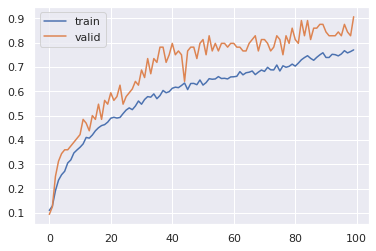

In [26]:
# Capturing learning history per epoch
hist5 = pd.DataFrame(history5.history)
hist5["epoch"] = history5.epoch

# Plotting the accuracies at different epochs
plt.plot(hist5["accuracy"])
plt.plot(hist5["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

### Model Evaluation

**Observations**
- model5 did generalize well, where the performance of the validation set was better than the testing set.

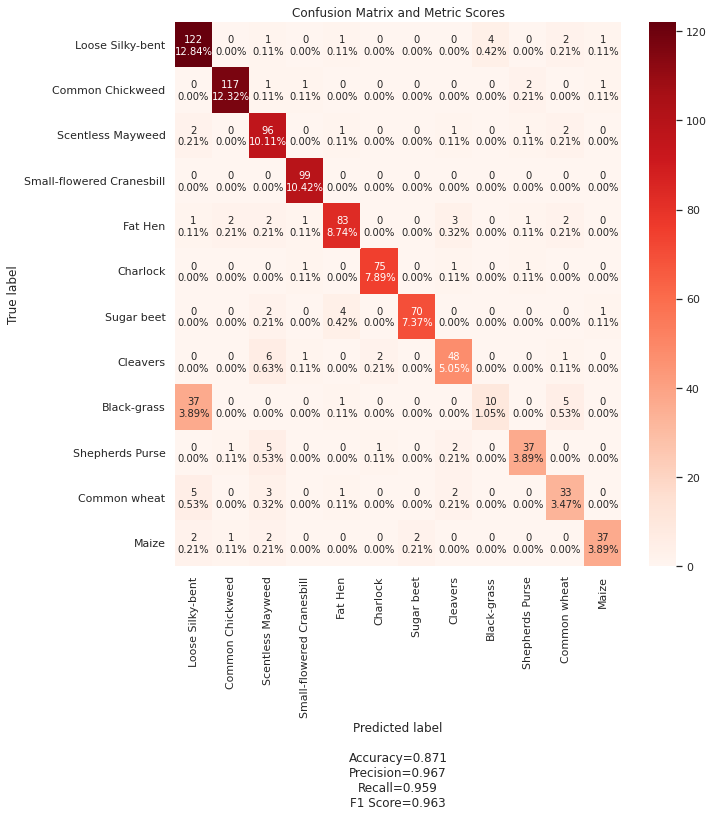

In [27]:
y_pred5=model5.predict(X_test)
y_pred5_classes = np.argmax(y_pred5,axis=1)
cm5 = confusion_matrix(np.array(y_test), y_pred5_classes)

confusion_matrix_and_metrics(cm5)

**Observations**
- model5 achieved an accuracy of 87.1% and f1 score of 96.3% on the test set.
- So far mode5 is the best model among all models.
- Let's see if we can achieve a better performance if we don't use maxpooling and use instead a stride of 2 in the con layers.

### model6
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 40 kernels with a kernel size of 5x5. The second will have 80 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3. Instead of using maxpooling layer we will use a stride of (2,2) for each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 32 nodes, second hidden layer will have 32 nodes as well. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [28]:
#Initialize model6
model6 = Sequential()
#Adding four conv layers with a stride of (2,2) instead of maxpooling layers and dropouts as explained above
model6.add(Conv2D(filters = 40, kernel_size = (2,2),strides=(2,2),padding = 'Same', 
                 activation ='relu'))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters = 80, kernel_size = (3,3),strides=(2,2),padding = 'Same', 
                 activation ='relu'))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters = 128, kernel_size = (3,3),strides=(2,2),padding = 'Same', 
                 activation ='relu'))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters = 128, kernel_size = (3,3),strides=(2,2),padding = 'Same', 
                 activation ='relu'))
model6.add(Dropout(0.2))
#Flatting the output of the last conv layer to a vector
model6.add(Flatten())
#Adding the two dense layers with dropouts.
model6.add(Dense(32, activation = "relu"))
model6.add(Dropout(0.2))
model6.add(Dense(32, activation = "relu"))
model6.add(Dropout(0.2))
#Adding the output layers
model6.add(Dense(12, activation = "softmax"))
#Choosing Adam as optimizer with LR of 0.0005
optimizer = optimizer=optimizers.Adam(learning_rate=0.0005)
#Compiling model6
model6.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#Fitting the data to the augmented training data and capturnig the history.
history6 = model6.fit(train_generator, validation_data=(validationX, validationY), epochs=100,use_multiprocessing=True)

Epoch 1/100
48/48 [==============================] - 13s 237ms/step - loss: 2.4555 - accuracy: 0.1164 - val_loss: 2.4581 - val_accuracy: 0.0469
Epoch 2/100
48/48 [==============================] - 11s 233ms/step - loss: 2.4397 - accuracy: 0.1181 - val_loss: 2.4290 - val_accuracy: 0.1562
Epoch 3/100
48/48 [==============================] - 11s 232ms/step - loss: 2.3795 - accuracy: 0.1428 - val_loss: 2.2546 - val_accuracy: 0.3281
Epoch 4/100
48/48 [==============================] - 11s 233ms/step - loss: 2.2089 - accuracy: 0.2388 - val_loss: 2.0323 - val_accuracy: 0.2969
Epoch 5/100
48/48 [==============================] - 11s 235ms/step - loss: 2.1066 - accuracy: 0.2770 - val_loss: 1.8522 - val_accuracy: 0.3438
Epoch 6/100
48/48 [==============================] - 11s 232ms/step - loss: 2.0575 - accuracy: 0.2885 - val_loss: 1.7992 - val_accuracy: 0.3750
Epoch 7/100
48/48 [==============================] - 11s 233ms/step - loss: 2.0103 - accuracy: 0.2977 - val_loss: 1.7625 - val_accuracy:

#### Plotting the train and validation accuracy

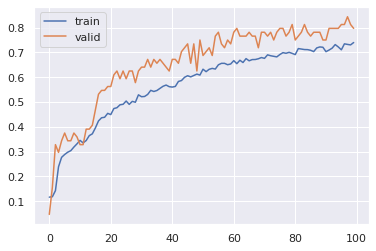

In [29]:
# Capturing learning history per epoch
hist6 = pd.DataFrame(history6.history)
hist6["epoch"] = history6.epoch

# Plotting the accuracies at different epochs
plt.plot(hist6["accuracy"])
plt.plot(hist6["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Observations**
- model6 did generalize well(no overfitting), the performance on validation set is better than training set.

### Model Evaluation

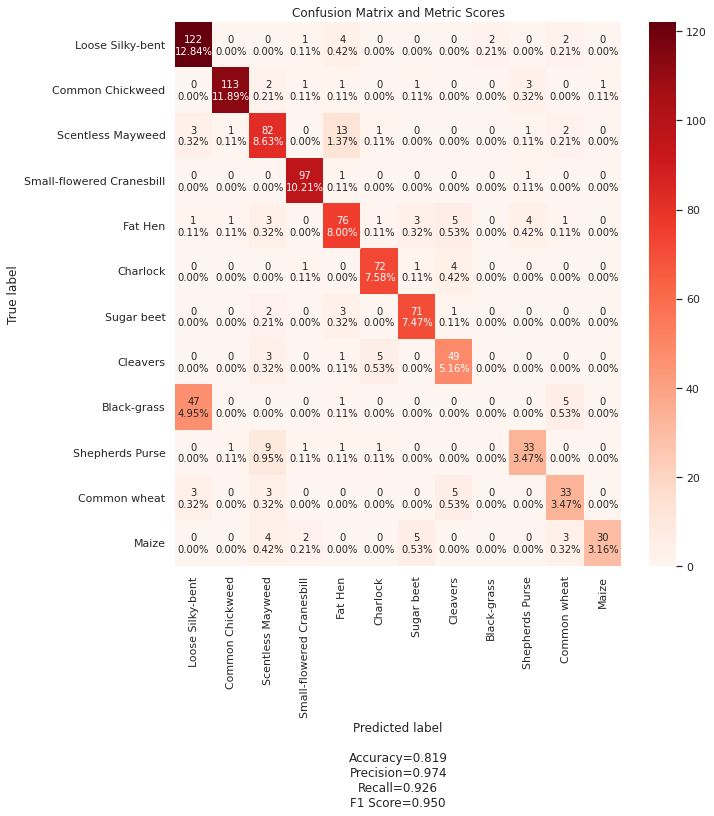

In [30]:
y_pred6=model6.predict(X_test)
y_pred6_classes = np.argmax(y_pred6,axis=1)
cm6 = confusion_matrix(np.array(y_test), y_pred6_classes)

confusion_matrix_and_metrics(cm6)

**Observations**
- model6 achieved an accuracy of 81.9% and f1 score of 95% on the unseen data(test set)
- model6 comes second after model5 among all models.
- Let's try a denser fully connected layers with maxpooling to see if we can achieve better performance.

### model7
- We will use 4 conv layers with padding and a Relu activation, the first layer will have 40 kernels with a kernel size of 5x5. The second will have 80 kernels with a kernel size of 3x3, the third and fourth layers will 128 kernels with a kernel size of 3x3.
- We will use max pooling with a kernel size of 2x2 and a stride of 2 for each ax, this will be done after each conv layer.
- We will use 2 fully-connected hidden layers with ReLu activation: First hidden layer will have 64 nodes, second hidden layer will have 48 nodes. This will be added after the last maxpooling layer.
- Output layer with 12 nodes(one for each class) will that will have a softmax activation function.
- We will use dropout control overfitting.

In [31]:
#Initialize model7
model7 = Sequential()
#Adding four conv layers with maxpooling layer and dropout after each conv layer as explained above.
model7.add(Conv2D(filters = 40, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters = 80, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters = 128, kernel_size = (3,3),  padding= 'Same', 
                 activation ='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.2))
#Flatting the output of the last maxpooling layer to a vector
model7.add(Flatten())
#Adding two dense layers with dropouts
model7.add(Dense(64, activation = "relu"))
model7.add(Dropout(0.2))
model7.add(Dense(48, activation = "relu"))
model7.add(Dropout(0.2))
#Adding output layer with softmax activation
model7.add(Dense(12, activation = "softmax"))
#Choosing Adam as optimizer with LR of 0.00075
optimizer = optimizer=optimizers.Adam(learning_rate=0.00075)
#Compiling model7
model7.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#Fitting model7 to the augmented training data
history7=model7.fit(train_generator, validation_data=(validationX, validationY), epochs=100,use_multiprocessing=True)  

Epoch 1/100
48/48 [==============================] - 13s 246ms/step - loss: 2.4708 - accuracy: 0.1197 - val_loss: 2.4687 - val_accuracy: 0.1094
Epoch 2/100
48/48 [==============================] - 14s 274ms/step - loss: 2.3323 - accuracy: 0.1977 - val_loss: 2.1773 - val_accuracy: 0.2656
Epoch 3/100
48/48 [==============================] - 12s 243ms/step - loss: 2.0868 - accuracy: 0.2836 - val_loss: 1.8936 - val_accuracy: 0.3281
Epoch 4/100
48/48 [==============================] - 12s 242ms/step - loss: 1.9404 - accuracy: 0.3286 - val_loss: 1.7808 - val_accuracy: 0.3438
Epoch 5/100
48/48 [==============================] - 12s 239ms/step - loss: 1.8363 - accuracy: 0.3493 - val_loss: 1.6632 - val_accuracy: 0.4219
Epoch 6/100
48/48 [==============================] - 12s 243ms/step - loss: 1.7933 - accuracy: 0.3763 - val_loss: 1.6119 - val_accuracy: 0.4219
Epoch 7/100
48/48 [==============================] - 11s 234ms/step - loss: 1.7017 - accuracy: 0.4062 - val_loss: 1.5253 - val_accuracy:

#### Plotting the train and validation accuracy

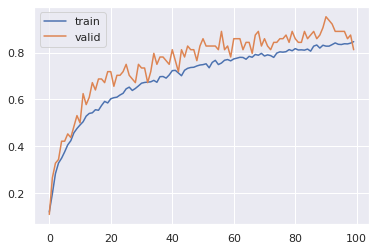

In [32]:
# Capturing learning history per epoch
hist7 = pd.DataFrame(history7.history)
hist7["epoch"] = history7.epoch

# Plotting the losses at different epochs
plt.plot(hist7["accuracy"])
plt.plot(hist7["val_accuracy"])
plt.legend(("train", "valid"), loc=0)

**Observations**
- model7 did generalize well, there is no overfitting.

### Model Evaluation

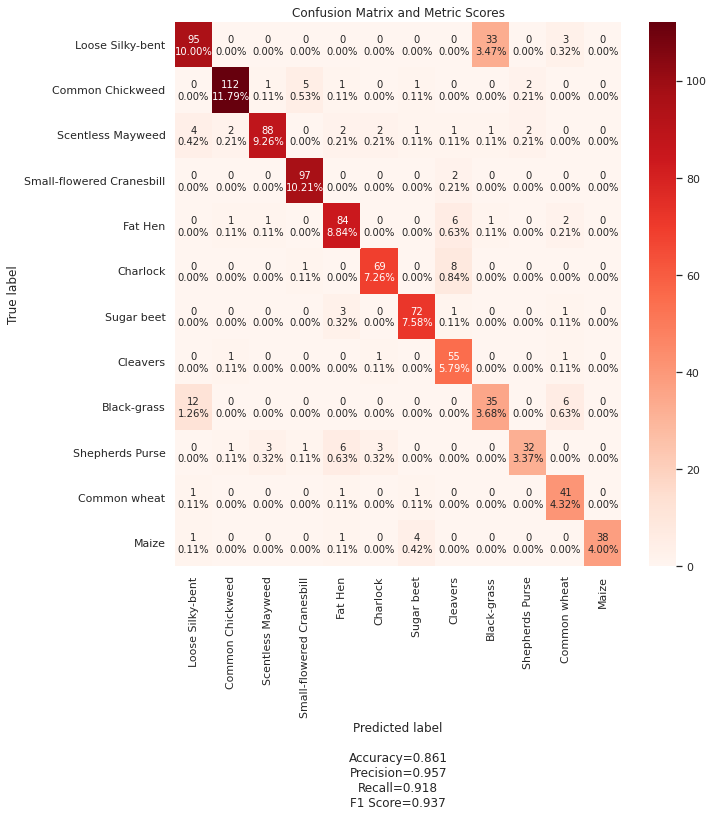

In [33]:
y_pred7=model7.predict(X_test)
y_pred7_classes = np.argmax(y_pred7,axis=1)
cm7 = confusion_matrix(np.array(y_test), y_pred7_classes)

confusion_matrix_and_metrics(cm7)

**Observations**
- model7 achieved an accuracy of 86.1% and f1 score of 93.7%
- model5 still our best performent model, which achieved the highest accuracy and f1 scores, and generalized very well.

### Predicting and Visualizing test images with indexes: 0,3,33,36, and 59

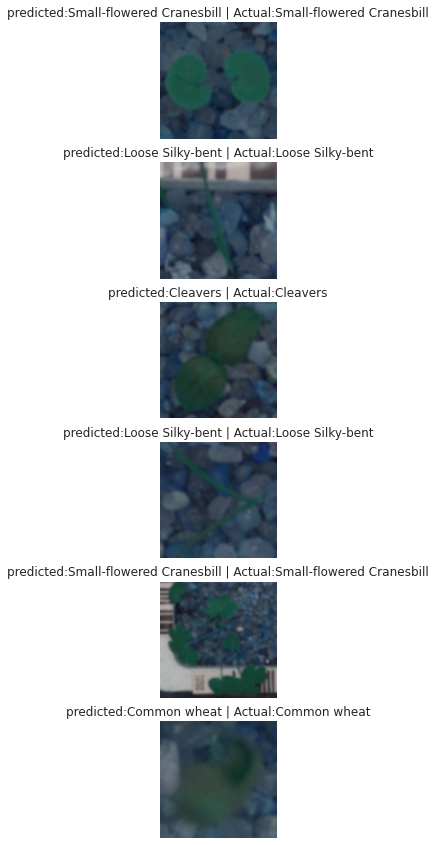

In [35]:
fig = plt.figure(figsize = (15,15))
#list of the images indexes'
list_test=[0,3,33,36,59]
for i in range(0,6) :
  #Grid of 6 roes and 1 column to show the predicted image  
  ax = fig.add_subplot(6, 1, i+1)
  #Using model5(best model) to predict test image with index:i  and capturing the predicted class(index in CATEGIRIES list)
  indexPredicted =np.argmax(model5.predict(X_test[i].reshape(1,128,128,3)),axis=1)
  #Getting the actual class which will be its index in CATEGIRIES list
  indexActual = y_test.iloc[i]
  #Showing the image to predict, with the predict class and actual class as a title
  plt.title("predicted:"+CATEGORIES[indexPredicted[0]]+" | Actual:"+CATEGORIES[indexActual.Label])
  plt.imshow(X_test[i])
  plt.axis('off')
plt.show()


**Observations**
- model5 correctly predicted the given test images.

## Conclusion

- model5 achieved the best performance with f1 score of:96.3% and accuracy of:87.1 , followed by model6 with f1 score of:95% and accuracy of:81.9 , then comes third model7 with f1 score of:93.7% and accuracy of:86.1%.

- CNN excels and performs very well on larger datasets, that can explain why all the models build on augmented training set  outperformed the four models built on the original training set.

- CNNs take the full 2D-image as input in order to perform feature extraction. So **CNNs do not lose the image's spatial structure, which makes them more suitable for working with image datasets.**. We could achieved even better performance if we had better images, for example some of the images showed almost only the background and only a very small tiny percentage of the image represented the plant(the class)